# 이미지 어디까지 우려볼까?

* Augmentation을 모델 학습에 적용하기
* Augmentation의 적용을 통한 학습 효과 확인하기
* 최신 data augmentation 기법 구현 및 활용하기

## Augmentation 적용 (1) 데이터 불러오기

In [ ]:
# 필요한 라이브러리 불러오기
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [ ]:
# GPU 환경 확인
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

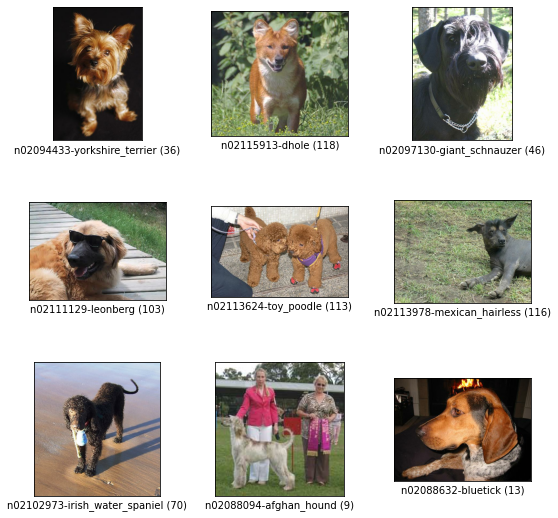

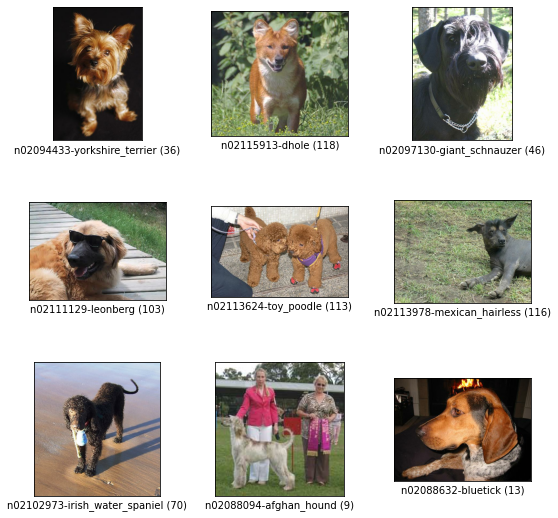

In [ ]:
tfds.show_examples(ds_train, ds_info)

## Augmentation 적용 (2) Augmentation 적용하기

In [ ]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [ ]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

In [ ]:
# 데이터셋(ds)을 가공하는 메인함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
    ds = ds.map(
        normalize_and_resize_img,  # 기본적인 전처리 함수 적용
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [ ]:
def augment2(image,label):
    image = tf.image.central_crop(image, np.random.uniform(0.50, 1.00))
    image = tf.image.resize(image, [224, 224])
    return image, label

## Augmentation 적용 (3) 비교실험 하기

In [ ]:
num_classes = ds_info.features["label"].num_classes
'''
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
'''

"\nresnet50 = keras.models.Sequential([\n    keras.applications.resnet.ResNet50(\n        include_top=False,\n        weights='imagenet',\n        input_shape=(224,224,3),\n        pooling='avg',\n    ),\n    keras.layers.Dense(num_classes, activation='softmax')\n])\n"

In [ ]:
'''
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
'''

"\naug_resnet50 = keras.models.Sequential([\n    keras.applications.resnet.ResNet50(\n        include_top=False,\n        weights='imagenet',\n        input_shape=(224,224,3),\n        pooling='avg',\n    ),\n    keras.layers.Dense(num_classes, activation='softmax')\n])\n"

In [ ]:

(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)


In [ ]:
'''
#EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수
EPOCH = 3

resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)
'''

"\n#EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수\nEPOCH = 3\n\nresnet50.compile(\n    loss='sparse_categorical_crossentropy',\n    optimizer=tf.keras.optimizers.SGD(lr=0.01),\n    metrics=['accuracy'],\n)\n\nhistory_resnet50_no_aug = resnet50.fit(\n    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용\n    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),\n    validation_steps=int(ds_info.splits['test'].num_examples/16),\n    epochs=EPOCH,\n    validation_data=ds_test,\n    verbose=1,\n    use_multiprocessing=True,\n)\n"

In [ ]:
'''
aug_resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)
'''

"\naug_resnet50.compile(\n    loss='sparse_categorical_crossentropy',\n    optimizer=tf.keras.optimizers.SGD(lr=0.01),\n    metrics=['accuracy'],\n)\n\nhistory_resnet50_aug = aug_resnet50.fit(\n    ds_train_aug, # augmentation 적용한 데이터셋 사용\n    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),\n    validation_steps=int(ds_info.splits['test'].num_examples/16),\n    epochs=EPOCH,\n    validation_data=ds_test,\n    verbose=1,\n    use_multiprocessing=True,\n)\n"

In [ ]:
'''
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.show()
'''

"\nplt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')\nplt.plot(history_resnet50_aug.history['val_accuracy'], 'b')\nplt.title('Model validation accuracy')\nplt.ylabel('Accuracy')\nplt.xlabel('Epoch')\nplt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')\nplt.show()\n"

In [ ]:
'''
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.grid(True)
plt.ylim(0.50, 0.80)    # 출력하고자 하는  Accuracy 범위를 지정해 주세요. 
#plt.ylim(0.72, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()
'''

"\nplt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')\nplt.plot(history_resnet50_aug.history['val_accuracy'], 'b')\nplt.title('Model validation accuracy')\nplt.ylabel('Accuracy')\nplt.xlabel('Epoch')\nplt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')\nplt.grid(True)\nplt.ylim(0.50, 0.80)    # 출력하고자 하는  Accuracy 범위를 지정해 주세요. \n#plt.ylim(0.72, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. \nplt.show()\n"

## 심화 기법 (1) Cutmix Augmentation

### 1) 이미지 섞기

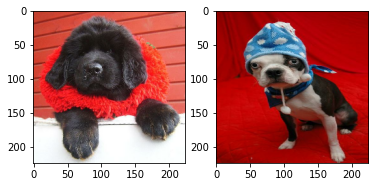

In [ ]:
import matplotlib.pyplot as plt

# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

In [ ]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

print('x : ', x_min, x_max)
print('y : ', y_min, y_max)

x :  tf.Tensor(116, shape=(), dtype=int32) tf.Tensor(224, shape=(), dtype=int32)
y :  tf.Tensor(51, shape=(), dtype=int32) tf.Tensor(216, shape=(), dtype=int32)


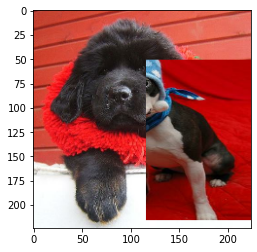

In [ ]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
plt.imshow(mixed_img.numpy())
plt.show()

### 2) 라벨 섞기
***

In [ ]:
# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

mixed_label = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.35514987,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.     

In [ ]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

## 심화 기법 (2) Mixup Augmentation

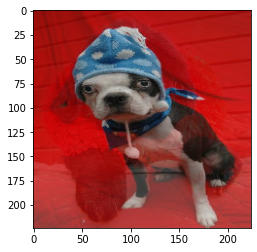

tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.7728615  0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.22713852 0.         0.
 0.         0.         0.         0.         

In [ ]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
plt.show()
print(mixed_label)

In [ ]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

# 프로젝트: CutMix 또는 Mixup 비교실험 하기

## Augmentation을 적용한 데이터셋 만들기

In [ ]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )

    if not is_test and with_aug:
        ds = ds.map(
            augment
        )

    ds = ds.batch(batch_size)

    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )

    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )

    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )

    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)

    return ds


elif를 사용한 부분에 if를 사용했었는데 오류가 계속났다.  
if에서 elif로 고치니 오류가 발생하지 않고 코드들이 잘 동작했다.  
~~이유는 아직 잘 모르겠다...~~


In [ ]:
def onehot(image, label) :
    label = tf.one_hot(label, num_classes)
    return image, label

## 모델 만들기

In [ ]:
(ds_train,ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train','test'],
    as_supervised = True,
    shuffle_files = True,
    with_info = True,
)

ds_train_no_aug = apply_normalize_on_dataset(ds_train,with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train,with_aug=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train,with_cutmix=True)
ds_train_cutmix_aug = apply_normalize_on_dataset(ds_train,with_aug=True,with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train,with_mixup=True)
ds_train_mixup_aug = apply_normalize_on_dataset(ds_train,with_aug=True,with_mixup=True)
ds_test = apply_normalize_on_dataset(ds_test,is_test=True)

In [ ]:
# No Augmentation

num_classes = ds_info.features["label"].num_classes
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [ ]:
# 기본 Augmentation

aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [ ]:
# No Augmentation + CutMix

cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [ ]:
# 기본 Augmentation + CutMix

aug_cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [ ]:
# No Augmentation + Mixup

mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [ ]:
# 기본 Augmentation + Mixup

aug_mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

## 모델 훈련하기

In [ ]:
# ResNet 50 (No Augmentation)
resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

# 기본 Augumentation
aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

# No Augmentation + cutmix
cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

# 기본 Augmentation + cutmix
aug_cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

# No Augmentation + mixup
mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

# 기본 Augmentation + mixup
aug_mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
EPOCH = 40

In [ ]:
# ResNet 50 (No Augmentation) 학습

history_resnet50_no_aug = resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/40
750/750 [==============================] - 101s 121ms/step - loss: 2.2843 - accuracy: 0.4324 - val_loss: 2.9005 - val_accuracy: 0.2849
Epoch 2/40
750/750 [==============================] - 89s 119ms/step - loss: 0.9670 - accuracy: 0.7254 - val_loss: 1.1927 - val_accuracy: 0.6498
Epoch 3/40
750/750 [==============================] - 89s 119ms/step - loss: 0.5163 - accuracy: 0.8558 - val_loss: 1.2900 - val_accuracy: 0.6384
Epoch 4/40
750/750 [==============================] - 89s 119ms/step - loss: 0.2772 - accuracy: 0.9320 - val_loss: 1.0357 - val_accuracy: 0.7030
Epoch 5/40
750/750 [==============================] - 89s 119ms/step - loss: 0.1452 - accuracy: 0.9713 - val_loss: 0.9680 - val_accuracy: 0.7250
Epoch 6/40
750/750 [==============================] - 90s 119ms/step - loss: 0.0748 - accuracy: 0.9899 - val_loss: 0.9550 - val_accuracy: 0.7357
Epoch 7/40
750/750 [==============================] - 89s 118ms/step - loss: 0.0489 - accuracy: 0.9949 - val_loss: 1.0053 - val_a

In [ ]:
# 기본 Augumentation

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/40
750/750 [==============================] - 99s 121ms/step - loss: 2.3040 - accuracy: 0.4258 - val_loss: 3.1558 - val_accuracy: 0.2519
Epoch 2/40
750/750 [==============================] - 90s 120ms/step - loss: 0.9609 - accuracy: 0.7234 - val_loss: 1.2955 - val_accuracy: 0.6365
Epoch 3/40
750/750 [==============================] - 90s 119ms/step - loss: 0.5666 - accuracy: 0.8378 - val_loss: 1.3250 - val_accuracy: 0.6221
Epoch 4/40
750/750 [==============================] - 89s 119ms/step - loss: 0.3130 - accuracy: 0.9187 - val_loss: 1.0029 - val_accuracy: 0.7111
Epoch 5/40
750/750 [==============================] - 90s 120ms/step - loss: 0.1900 - accuracy: 0.9579 - val_loss: 0.9948 - val_accuracy: 0.7174
Epoch 6/40
750/750 [==============================] - 90s 120ms/step - loss: 0.1394 - accuracy: 0.9689 - val_loss: 1.0870 - val_accuracy: 0.7064
Epoch 7/40
750/750 [==============================] - 90s 120ms/step - loss: 0.0731 - accuracy: 0.9902 - val_loss: 0.9656 - val_ac

In [ ]:
# No Augmentation + cutmix

history_resnet50_cutmix = cutmix_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/40
750/750 [==============================] - 98s 119ms/step - loss: 2.2740 - accuracy: 0.4306 - val_loss: 3.0811 - val_accuracy: 0.2455
Epoch 2/40
750/750 [==============================] - 88s 118ms/step - loss: 0.9351 - accuracy: 0.7303 - val_loss: 1.2972 - val_accuracy: 0.6323
Epoch 3/40
750/750 [==============================] - 88s 118ms/step - loss: 0.5145 - accuracy: 0.8579 - val_loss: 1.1833 - val_accuracy: 0.6599
Epoch 4/40
750/750 [==============================] - 88s 118ms/step - loss: 0.2601 - accuracy: 0.9348 - val_loss: 1.3656 - val_accuracy: 0.6186
Epoch 5/40
750/750 [==============================] - 89s 119ms/step - loss: 0.2323 - accuracy: 0.9442 - val_loss: 1.1596 - val_accuracy: 0.6760
Epoch 6/40
750/750 [==============================] - 89s 118ms/step - loss: 0.0997 - accuracy: 0.9818 - val_loss: 0.9590 - val_accuracy: 0.7338
Epoch 7/40
750/750 [==============================] - 90s 119ms/step - loss: 0.0679 - accuracy: 0.9905 - val_loss: 0.9961 - val_ac

In [ ]:
# 기본 Augmentation + cutmix

history_resnet50_aug_cutmix = aug_cutmix_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/40
750/750 [==============================] - 98s 119ms/step - loss: 2.2647 - accuracy: 0.4336 - val_loss: 3.0774 - val_accuracy: 0.2635
Epoch 2/40
750/750 [==============================] - 89s 118ms/step - loss: 0.9222 - accuracy: 0.7313 - val_loss: 1.3800 - val_accuracy: 0.6019
Epoch 3/40
750/750 [==============================] - 88s 118ms/step - loss: 0.5202 - accuracy: 0.8569 - val_loss: 1.2511 - val_accuracy: 0.6453
Epoch 4/40
750/750 [==============================] - 89s 119ms/step - loss: 0.2728 - accuracy: 0.9317 - val_loss: 0.9954 - val_accuracy: 0.7162
Epoch 5/40
750/750 [==============================] - 89s 119ms/step - loss: 0.1372 - accuracy: 0.9749 - val_loss: 1.0754 - val_accuracy: 0.7009
Epoch 6/40
750/750 [==============================] - 89s 118ms/step - loss: 0.0894 - accuracy: 0.9866 - val_loss: 1.0117 - val_accuracy: 0.7211
Epoch 7/40
750/750 [==============================] - 89s 119ms/step - loss: 0.0528 - accuracy: 0.9923 - val_loss: 0.9303 - val_ac

In [ ]:
# No Augmentation + mixup

history_resnet50_mixup = mixup_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/40
750/750 [==============================] - 99s 120ms/step - loss: 2.2942 - accuracy: 0.4250 - val_loss: 2.8752 - val_accuracy: 0.2927
Epoch 2/40
750/750 [==============================] - 90s 119ms/step - loss: 0.9926 - accuracy: 0.7193 - val_loss: 1.3002 - val_accuracy: 0.6279
Epoch 3/40
750/750 [==============================] - 89s 119ms/step - loss: 0.5624 - accuracy: 0.8418 - val_loss: 1.0863 - val_accuracy: 0.6863
Epoch 4/40
750/750 [==============================] - 90s 120ms/step - loss: 0.3021 - accuracy: 0.9231 - val_loss: 1.1690 - val_accuracy: 0.6758
Epoch 5/40
750/750 [==============================] - 90s 120ms/step - loss: 0.1643 - accuracy: 0.9673 - val_loss: 1.0342 - val_accuracy: 0.7136
Epoch 6/40
750/750 [==============================] - 90s 121ms/step - loss: 0.1234 - accuracy: 0.9757 - val_loss: 1.0582 - val_accuracy: 0.7069
Epoch 7/40
750/750 [==============================] - 91s 121ms/step - loss: 0.0763 - accuracy: 0.9889 - val_loss: 0.9916 - val_ac

In [ ]:
# 기본 Augmentation + mixup

history_resnet50_aug_mixup = aug_mixup_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/40
750/750 [==============================] - 98s 120ms/step - loss: 2.3064 - accuracy: 0.4220 - val_loss: 2.9161 - val_accuracy: 0.2788
Epoch 2/40
750/750 [==============================] - 89s 118ms/step - loss: 0.9356 - accuracy: 0.7352 - val_loss: 1.2423 - val_accuracy: 0.6420
Epoch 3/40
750/750 [==============================] - 89s 119ms/step - loss: 0.4989 - accuracy: 0.8622 - val_loss: 1.0880 - val_accuracy: 0.6802
Epoch 4/40
750/750 [==============================] - 89s 118ms/step - loss: 0.2515 - accuracy: 0.9402 - val_loss: 1.0538 - val_accuracy: 0.6974
Epoch 5/40
750/750 [==============================] - 94s 125ms/step - loss: 0.1319 - accuracy: 0.9754 - val_loss: 0.9732 - val_accuracy: 0.7220
Epoch 6/40
750/750 [==============================] - 90s 120ms/step - loss: 0.1130 - accuracy: 0.9794 - val_loss: 1.0138 - val_accuracy: 0.7097
Epoch 7/40
750/750 [==============================] - 90s 120ms/step - loss: 0.0635 - accuracy: 0.9904 - val_loss: 0.9670 - val_ac

## 훈련 과정 시각화하기

Train Accuracy & Loss

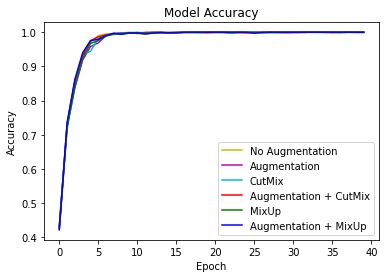

In [ ]:
# Training Accuracy

plt.plot(history_resnet50_no_aug.history['accuracy'], 'y')
plt.plot(history_resnet50_aug.history['accuracy'], 'm')
plt.plot(history_resnet50_cutmix.history['accuracy'], 'c')
plt.plot(history_resnet50_aug_cutmix.history['accuracy'], 'r')
plt.plot(history_resnet50_mixup.history['accuracy'], 'g')
plt.plot(history_resnet50_aug_mixup.history['accuracy'], 'b')

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'Augmentation','CutMix',
           'Augmentation + CutMix','MixUp','Augmentation + MixUp'],loc='lower right')
plt.show()

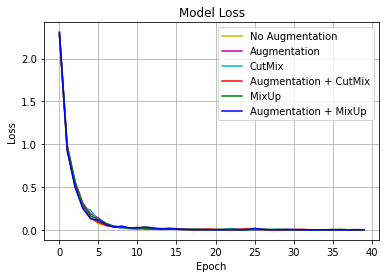

In [ ]:
# Training Loss

plt.plot(history_resnet50_no_aug.history['loss'], 'y')
plt.plot(history_resnet50_aug.history['loss'], 'm')
plt.plot(history_resnet50_cutmix.history['loss'], 'c')
plt.plot(history_resnet50_aug_cutmix.history['loss'], 'r')
plt.plot(history_resnet50_mixup.history['loss'], 'g')
plt.plot(history_resnet50_aug_mixup.history['loss'], 'b')

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'Augmentation','CutMix',
           'Augmentation + CutMix','MixUp','Augmentation + MixUp'],loc='upper right')
plt.grid(True)
plt.show()

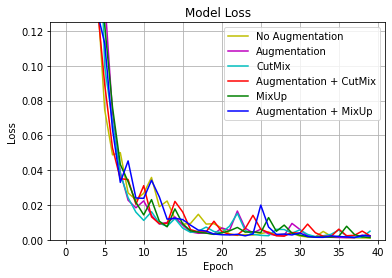

In [ ]:
# Training Loss

plt.plot(history_resnet50_no_aug.history['loss'], 'y')
plt.plot(history_resnet50_aug.history['loss'], 'm')
plt.plot(history_resnet50_cutmix.history['loss'], 'c')
plt.plot(history_resnet50_aug_cutmix.history['loss'], 'r')
plt.plot(history_resnet50_mixup.history['loss'], 'g')
plt.plot(history_resnet50_aug_mixup.history['loss'], 'b')

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'Augmentation','CutMix',
           'Augmentation + CutMix','MixUp','Augmentation + MixUp'],loc='upper right')
plt.grid(True)
plt.ylim(0, 0.125)
plt.show()

Validation Accuracy & Loss

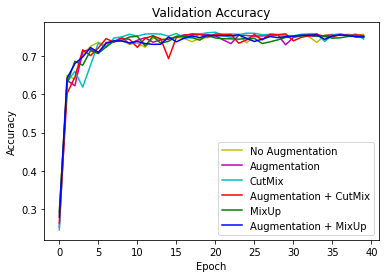

In [ ]:
# Validation Accuracy

plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'y')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'm')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'c')
plt.plot(history_resnet50_aug_cutmix.history['val_accuracy'], 'r')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'g')
plt.plot(history_resnet50_aug_mixup.history['val_accuracy'], 'b')

plt.title('Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'Augmentation','CutMix',
           'Augmentation + CutMix','MixUp','Augmentation + MixUp'],loc='lower right')
plt.show()

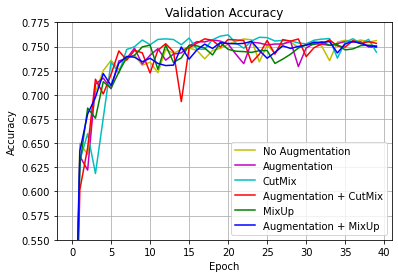

In [ ]:
# Validation Accuracy

plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'y')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'm')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'c')
plt.plot(history_resnet50_aug_cutmix.history['val_accuracy'], 'r')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'g')
plt.plot(history_resnet50_aug_mixup.history['val_accuracy'], 'b')

plt.title('Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'Augmentation','CutMix',
           'Augmentation + CutMix','MixUp','Augmentation + MixUp'],loc='lower right')
plt.grid(True)
plt.ylim(0.55, 0.775)
plt.show()

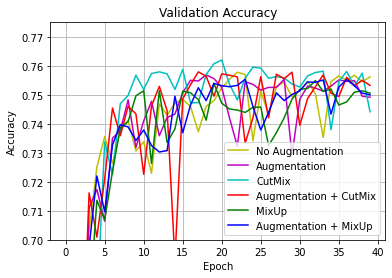

In [ ]:
# Validation Accuracy

plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'y')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'm')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'c')
plt.plot(history_resnet50_aug_cutmix.history['val_accuracy'], 'r')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'g')
plt.plot(history_resnet50_aug_mixup.history['val_accuracy'], 'b')

plt.title('Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'Augmentation','CutMix',
           'Augmentation + CutMix','MixUp','Augmentation + MixUp'],loc='lower right')
plt.grid(True)
plt.ylim(0.7, 0.775)
plt.show()

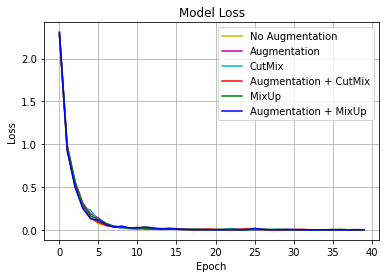

In [ ]:
# Validation Loss

plt.plot(history_resnet50_no_aug.history['loss'], 'y')
plt.plot(history_resnet50_aug.history['loss'], 'm')
plt.plot(history_resnet50_cutmix.history['loss'], 'c')
plt.plot(history_resnet50_aug_cutmix.history['loss'], 'r')
plt.plot(history_resnet50_mixup.history['loss'], 'g')
plt.plot(history_resnet50_aug_mixup.history['loss'], 'b')

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'Augmentation','CutMix',
           'Augmentation + CutMix','MixUp','Augmentation + MixUp'],loc='upper right')
plt.grid(True)
plt.show()

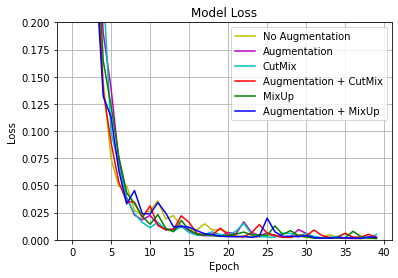

In [ ]:
# Validation Loss

plt.plot(history_resnet50_no_aug.history['loss'], 'y')
plt.plot(history_resnet50_aug.history['loss'], 'm')
plt.plot(history_resnet50_cutmix.history['loss'], 'c')
plt.plot(history_resnet50_aug_cutmix.history['loss'], 'r')
plt.plot(history_resnet50_mixup.history['loss'], 'g')
plt.plot(history_resnet50_aug_mixup.history['loss'], 'b')

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'Augmentation','CutMix',
           'Augmentation + CutMix','MixUp','Augmentation + MixUp'],loc='upper right')
plt.grid(True)
plt.ylim(0, 0.2)
plt.show()

## Augmentation에 의한 모델 성능 비교

* Validation Accuracy, Validation Loss 그래프를 보면 사실 여섯 가지의 모델의 성능적인 면에서 별반 차이가 없다는 것을 알 수 있다.  
* 오히려 학습을 진행할수록 Augmentation을 적용하지 않은 모델인 No Augmentation의 성능이 가장 높다는 결과가 나왔다.  
* 대체적으로 Augmentation을 적용했을 경우에 모델의 성능 향상이 있을 것이지만, 모든 경우에 그렇지 않다는 사실을 알 수 있었다(적어도 이 데이터에서는 아님).


# <kbd>회고</kbd>


루브릭에서 "Augmentation 적용을 통해 Augmentaion 미적용시 대비 5% 이상의 성능향상을 확인함"이라는 항목이 있지만 이는 달성할 수 없을 것 같다.